In [ ]:
## Imports

%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from PIL import Image

import scipy.misc
from skimage import measure   

import time
import os
import zipfile as zf
import tarfile
import csv
import pickle
import urllib
import pandas as pd


from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

In [2]:
## Dataset Parameters ##
WORKING_DIRECTORY = '/media/dean/datastore/ROAD_COCO/darknet/data'
COCO_DIRECTORY = os.path.join(WORKING_DIRECTORY, 'coco')
IMAGES_DIRECTORY = os.path.join(COCO_DIRECTORY, 'images', 'train2014')
img_prefix = 'COCO_train2014_0000'


UNCHANGED_COCO_ANNOTATIONS_FILE = os.path.join(WORKING_DIRECTORY, 'coco','annotations' , 'instances_train2014.json')
FIXED_COCO_ANNOTATIONS_FILE = os.path.join(WORKING_DIRECTORY, 'coco','annotations' , 'fixed_instances_train2014.json')
ROAD_COCO_ANNOTATIONS_FILE = os.path.join(WORKING_DIRECTORY, 'coco','annotations' , 'roadcoco_instances_train2014.json')


COCO_FIXES_CSV = os.path.join(WORKING_DIRECTORY, 'COCO_Trucks.csv')
HEADER_ROW=['ID', 'FileName', 'ImageUrl', 'KEEP']

COCO_TRUCK_CAR_DELETES_CSV = os.path.join(WORKING_DIRECTORY, 'coco_cars_trucks.csv')

In [3]:
%matplotlib inline
from pycocotools.coco import COCO
import skimage.io as io
import pylab

images_directory = IMAGES_DIRECTORY
road_coco = COCO(UNCHANGED_COCO_ANNOTATIONS_FILE)

categories = road_coco.loadCats(road_coco.getCatIds())
category_names = [category['name'] for category in categories]
print('\nCustom COCO categories: \n{}\n'.format(' '.join(category_names)))

loading annotations into memory...
Done (t=8.30s)
creating index...
index created!

Custom COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush



In [4]:
## Extract Labels ##
image_changes = pd.read_csv(COCO_FIXES_CSV, names=HEADER_ROW, skiprows=1)
image_changes.head()

,ID,FileName,ImageUrl,KEEP
0,155652,COCO_train2014_000000155652.jpg,http://farm3.staticflickr.com/2599/4078412191_...,y
1,253959,COCO_train2014_000000253959.jpg,http://farm4.staticflickr.com/3765/9371427949_...,c
2,253975,COCO_train2014_000000253975.jpg,http://farm1.staticflickr.com/62/211829230_23a...,c
3,188440,COCO_train2014_000000188440.jpg,http://farm2.staticflickr.com/1075/1438769690_...,c
4,417822,COCO_train2014_000000417822.jpg,http://farm9.staticflickr.com/8514/8453715459_...,y


In [5]:
## DELETE BAD TRUCKS/CHANGE BAD TRUCK LABELS


import json



filename = UNCHANGED_COCO_ANNOTATIONS_FILE
with open(filename, 'r') as f:
    data = json.load(f)
    # Make COCO changes
    for image_change in image_changes.as_matrix():
        
        if image_change[3] == 'n':
            #Get all annotations associated with the image
            anns = road_coco.getAnnIds(imgIds=[image_change[0]])
            
            #Delete all annotations associated with image
            for d in data['annotations']: # Loops through all the nodes in json object
                if d and int(d['id']) in anns:
                    # print('Deleting:', d)
                    data['annotations'].remove(d)
            
        elif image_change[3] == 'c':
            # Change all corresponding labels under image to 'car'
            anns = road_coco.getAnnIds(imgIds=[image_change[0]])
            truck_cat = road_coco.getCatIds(catNms=['truck'])[0]
            car_cat = road_coco.getCatIds(catNms=['car'])[0]
            
            for i, d in enumerate(data['annotations']): # Loops through all the nodes in json object
                for ann in anns:
                    if d and int(d['id']) == int(ann) \
                         and int(d['image_id']) == int(image_change[0]) \
                         and int(d['category_id']) == truck_cat:
                        
                        # print('Changing [', d['category_id'] ,']label to car:', d)
                        data['annotations'][i]['category_id'] = car_cat


with open(FIXED_COCO_ANNOTATIONS_FILE, 'w') as f:
    json.dump(data, f, indent=4)

/home/dean/miniconda3/envs/ros-kache/lib/python3.6/site-packages/ipykernel/__main__.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [6]:
## Extract Labels ##
image_deletions = pd.read_csv(COCO_TRUCK_CAR_DELETES_CSV, names=HEADER_ROW[:-1], skiprows=1)
image_deletions.head()

,ID,FileName,ImageUrl
0,344067,COCO_train2014_000000344067.jpg,http://farm8.staticflickr.com/7353/9715487608_...
1,114692,COCO_train2014_000000114692.jpg,http://farm3.staticflickr.com/2578/4259448398_...
2,319492,COCO_train2014_000000319492.jpg,http://farm9.staticflickr.com/8428/7718922324_...
3,24585,COCO_train2014_000000024585.jpg,http://farm6.staticflickr.com/5148/5606858964_...
4,114701,COCO_train2014_000000114701.jpg,http://farm3.staticflickr.com/2377/2243712589_...


In [7]:
## DELETE CARS/TRUCKS IMAGES

import json


filename = FIXED_COCO_ANNOTATIONS_FILE
with open(filename, 'r') as f:
    data = json.load(f)
    # Make COCO changes
    for image_deletion in image_deletions.as_matrix():
        try:
            img_id = int(image_deletion[0])
            #Get all annotations associated with the image
            anns = road_coco.getAnnIds(imgIds=[img_id])
            #Delete all annotations associated with image
            for d in data['annotations']: # Loops through all the nodes in json object
                if d and int(d['id']) in anns:
                    #print('Deleting:', d)
                    data['annotations'].remove(d)
        except ValueError:
            print('Error casting, skipping img_id:', image_deletion[0])
            continue
     
        
        
        


os.remove(filename)
with open(filename, 'w') as f:
    json.dump(data, f, indent=4)

/home/dean/miniconda3/envs/ros-kache/lib/python3.6/site-packages/ipykernel/__main__.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Error casting, skipping img_id:  
Error casting, skipping img_id:  


In [8]:
def remove_none(obj):
    if isinstance(obj, (list, tuple, set)):
        return type(obj)(remove_none(x) for x in obj if x is not None)
    elif isinstance(obj, type(dict)):
        return type(obj)((remove_none(k), remove_none(v)) for k, v in obj.items() if k is not None and v is not None)
    else:
        return obj

In [9]:
import json


filename = FIXED_COCO_ANNOTATIONS_FILE
with open(filename, 'r') as f:
    data = json.load(f)
    data['annotations'] = remove_none(data['annotations'])
    
    for i, d in enumerate(data['annotations']):
        # Check if width or heigh in bounding box is 0
        if d:
            # xstart, ystart, width, height
            area, bbox = d['area'], d['bbox']
            
            
            if float(bbox[3]) <= 0.0:
                print('Changing BoundingBox/Area Annotations:', bbox,'/',area)
                bbox[3] = 1.1
                data['annotations'][i]['bbox'] = bbox
            if float(bbox[2]) <= 0.0:
                print('Changing BoundingBox/Area Annotations:', bbox,'/',area)
                bbox[2] = 1.1
                data['annotations'][i]['bbox'] = bbox
                
            if float(area) <= 0.0:
                data['annotations'][i]['area'] = float(bbox[2])*float(bbox[3])
                     
        
        
        


os.remove(filename)
with open(filename, 'w') as f:
    json.dump(data, f, indent=4)

Changing BoundingBox/Area Annotations: [9.98, 188.56, 5.54, 0.0] / 0.0


In [10]:
import json


filename = FIXED_COCO_ANNOTATIONS_FILE
road_coco = COCO(FIXED_COCO_ANNOTATIONS_FILE) # fixed_instances_annoations file 
truck_cat = road_coco.getCatIds(catNms=['truck'])[0]
car_cat = road_coco.getCatIds(catNms=['car'])[0]
person_cat = road_coco.getCatIds(catNms=['person'])[0]
traffic_light_cat = road_coco.getCatIds(catNms=['traffic light'])[0]
stop_sign_cat = road_coco.getCatIds(catNms=['stop sign'])[0]
parking_meter_cat = road_coco.getCatIds(catNms=['parking meter'])[0]

keep_categories = [truck_cat, person_cat, car_cat, traffic_light_cat, stop_sign_cat, parking_meter_cat]
        
        
with open(filename, 'r') as f:
    data = json.load(f)
    #data['annotations'] = remove_none(data['annotations'])
    
    #Delete all annotations associated with image
    for d in data['annotations']: # Loops through all the nodes in json object
        # Delete Non-ROAD_COCO Categories #
        if d and int(d['category_id']) in keep_categories:
            #print('Skipping:', d['id'], 'with Category ID:', d['category_id'])
            continue
        else:
            #print('Deleting:', d['id'], 'with Category ID:', d['category_id'])
            data['annotations'].remove(d)
                     
        
        
        


os.remove(filename)


# Save as ROADCOCO annotations File
with open(FIXED_COCO_ANNOTATIONS_FILE, 'w') as f:
    json.dump(data, f, indent=4)

loading annotations into memory...
Done (t=8.50s)
creating index...
index created!


In [11]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

In [12]:
example_coco = COCO(FIXED_COCO_ANNOTATIONS_FILE)

loading annotations into memory...
Done (t=5.41s)
creating index...
index created!


In [13]:
categories = example_coco.loadCats(example_coco.getCatIds())
# category_names = [category['name'] for category in categories]
# print('Custom COCO categories: \n{}\n'.format(' '.join(category_names)))

# supercategory_names = set([category['supercategory'] for category in categories])
# print('Custom COCO supercategories: \n{}'.format(' '.join(supercategory_names)))
print(categories)

[{'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}, {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}, {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}, {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}, {'supercategory': 'vehicle', 'id': 7, 'name': 'train'}, {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}, {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}, {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}, {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}, {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'}, {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}, {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}, {'supercategory': 'animal', 'id': 16, 'name': 'bird'}, {'supercategory': 'animal', 'id': 17, 'name': 'cat'}, {'supercategory': 'animal', 'id': 18, 'name': 'dog'}, {'supercategory

In [14]:
category_ids = example_coco.getCatIds(catNms=list(category_names))
image_ids = example_coco.getImgIds()

image_data = example_coco.loadImgs(image_ids[np.random.randint(0, len(image_ids))])[0]
print(image_data)

{'license': 1, 'file_name': 'COCO_train2014_000000281665.jpg', 'coco_url': 'http://mscoco.org/images/281665', 'height': 290, 'width': 640, 'date_captured': '2013-11-14 19:54:38', 'flickr_url': 'http://farm8.staticflickr.com/7451/8728768734_bf73e7ea42_z.jpg', 'id': 281665}


[{'segmentation': [[603.93, 155.09, 602.11, 163.04, 593.82, 163.72, 593.13, 154.18, 597.45, 152.14, 602.34, 153.39, 604.27, 154.07]], 'area': 100.7802499999997, 'iscrowd': 0, 'image_id': 281665, 'bbox': [593.13, 152.14, 11.14, 11.58], 'category_id': 64, 'id': 26649}, {'segmentation': [[251.19, 289.26, 264.36, 289.67, 278.35, 233.71, 269.71, 217.25, 252.43, 199.15, 249.96, 197.91, 239.26, 216.43, 228.56, 257.16, 239.67, 279.79, 251.6, 289.26]], 'area': 2945.2032500000014, 'iscrowd': 0, 'image_id': 281665, 'bbox': [228.56, 197.91, 49.79, 91.76], 'category_id': 62, 'id': 104824}, {'segmentation': [[41.34, 284.83, 25.05, 234.72, 33.2, 219.69, 61.38, 197.14, 70.78, 204.66, 90.19, 258.53, 77.67, 286.71, 53.24, 286.09]], 'area': 3930.088749999999, 'iscrowd': 0, 'image_id': 281665, 'bbox': [25.05, 197.14, 65.14, 89.57], 'category_id': 62, 'id': 105822}, {'segmentation': [[234.08, 217.51, 226.64, 253.36, 213.78, 224.27, 228.67, 182.33, 232.05, 178.94, 250.32, 194.5, 232.05, 218.18]], 'area': 11

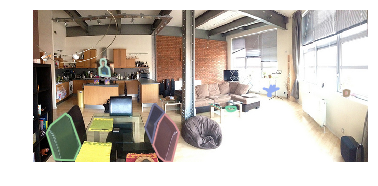

In [15]:
# load and display instance annotations
image = io.imread(os.path.join(images_directory ,image_data['file_name']))
plt.imshow(image); plt.axis('off')
pylab.rcParams['figure.figsize'] = (68.0, 120.0)
annotation_ids = example_coco.getAnnIds(imgIds=image_data['id'], catIds=category_ids, iscrowd=None)
annotations = example_coco.loadAnns(annotation_ids)
print(annotations)
example_coco.showAnns(annotations)

In [16]:
ann_ids = example_coco.getAnnIds()
print(len(ann_ids))

381426


In [17]:
#!java -jar /media/dean/49D9D6EB1BE53FC4/datasets/darknet/data/cocotoyolo.jar "/media/dean/49D9D6EB1BE53FC4/datasets/darknet/data/coco/annotations/fixed_instances_val2014.json" "/media/dean/49D9D6EB1BE53FC4/datasets/darknet/data/coco/images/val2014/" "all" "/media/dean/49D9D6EB1BE53FC4/datasets/darknet/data/coco/labels/fixed_val2014"

In [18]:
#!/media/dean/49D9D6EB1BE53FC4/datasets/darknet/darknet detector test /media/dean/49D9D6EB1BE53FC4/datasets/darknet/cfg/coco.data /media/dean/49D9D6EB1BE53FC4/datasets/darknet/cfg/yolov3.cfg backup/yolov3.backup -dont_show < /media/dean/49D9D6EB1BE53FC4/datasets/darknet/data/coco/labels/fixed_val2014/image_list.txt > /media/dean/49D9D6EB1BE53FC4/datasets/darknet/results/val_2014_results.json

In [19]:
#/home/anthony/darknet/darknet detector test /home/anthony/darknet/cfg/coco.data /home/anthony/darknet/cfg/yolov3.cfg backup/yolov3.backup -dont_show < /home/anthony/darknet/data/coco/labels/fixed_val2014/image_list.txt > /home/anthony/darknet/results/val_2014_results.json

In [20]:
## Imports

%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from PIL import Image

import scipy.misc
from skimage import measure   

import time
import os
import zipfile as zf
import tarfile
import csv
import pickle
import urllib
import pandas as pd

In [21]:
## Dataset Parameters ##
images_path = "{}{}".format( IMAGES_DIRECTORY, '*.jpg')
img_prefix = 'COCO_train2014_0000'
    
## VGG Labeler Dataset Extraction Parameters ##
VGG_ANNS_CSV = os.path.join(WORKING_DIRECTORY, 'night_detections.csv')
HEADER_ROW=['filename', 'file_size', 'file_attributes', 'region_count', 'region_id', 'region_shape_attributes', 'region_attributes']

In [22]:
def maybe_download(source_url, filename):
    if not os.path.exists(IMAGES_DIRECTORY):
        os.mkdir(IMAGES_DIRECTORY)
    
    filepath = os.path.join(IMAGES_DIRECTORY, filename)
    if not os.path.exists(filepath):
        filepath, _ = urllib.request.urlretrieve(source_url, filepath)
        statinfo = os.stat(filepath)
        print('')
        print('Succesfully downloaded:', filepath, '| % d MB.' % int(statinfo.st_size*1e-6))
    return filepath

In [23]:
## Extract Labels ##
annotations = pd.read_csv(VGG_ANNS_CSV, names=HEADER_ROW, skiprows=1)
annotations.head()

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,http://ec2-18-236-156-72.us-west-2.compute.ama...,35089,{},3,0,"{""name"":""rect"",""x"":608.801887512207,""y"":215.52...","{""type"":""car""}"
1,http://ec2-18-236-156-72.us-west-2.compute.ama...,35089,{},3,1,"{""name"":""rect"",""x"":68.84820938110352,""y"":231.7...","{""type"":"" car""}"
2,http://ec2-18-236-156-72.us-west-2.compute.ama...,35089,{},3,2,"{""name"":""rect"",""x"":800,""y"":202,""width"":19,""hei...","{""type"":""person""}"
3,http://ec2-18-236-156-72.us-west-2.compute.ama...,25037,{},3,0,"{""name"":""rect"",""x"":438.3702850341797,""y"":219.0...","{""type"":""car""}"
4,http://ec2-18-236-156-72.us-west-2.compute.ama...,25037,{},3,1,"{""name"":""rect"",""x"":328.9356918334961,""y"":226.0...","{""type"":"" car""}"


In [24]:
urlstofilepaths = {}
url_paths = set(annotations['filename'].tolist())

for url in url_paths:
    fname = os.path.split(url)[-1]
    urlstofilepaths[url] = maybe_download(url, os.path.join(IMAGES_DIRECTORY, img_prefix+fname))
print(urlstofilepaths)

{'http://ec2-18-236-156-72.us-west-2.compute.amazonaws.com/via/tests/data/night/night330.jpg': '/media/dean/datastore/ROAD_COCO/darknet/data/coco/images/train2014/COCO_train2014_0000night330.jpg', 'http://ec2-18-236-156-72.us-west-2.compute.amazonaws.com/via/tests/data/night/night160.jpg': '/media/dean/datastore/ROAD_COCO/darknet/data/coco/images/train2014/COCO_train2014_0000night160.jpg', 'http://ec2-18-236-156-72.us-west-2.compute.amazonaws.com/via/tests/data/night/night213.jpg': '/media/dean/datastore/ROAD_COCO/darknet/data/coco/images/train2014/COCO_train2014_0000night213.jpg', 'http://ec2-18-236-156-72.us-west-2.compute.amazonaws.com/via/tests/data/night/night449.jpg': '/media/dean/datastore/ROAD_COCO/darknet/data/coco/images/train2014/COCO_train2014_0000night449.jpg', 'http://ec2-18-236-156-72.us-west-2.compute.amazonaws.com/via/tests/data/night/night340.jpg': '/media/dean/datastore/ROAD_COCO/darknet/data/coco/images/train2014/COCO_train2014_0000night340.jpg', 'http://ec2-18-236-

In [25]:
fixed_coco = COCO(FIXED_COCO_ANNOTATIONS_FILE)

categories = fixed_coco.loadCats(fixed_coco.getCatIds())
category_names = [category['name'] for category in categories]
print('Custom COCO categories: \n{}\n'.format(' '.join(category_names)))

loading annotations into memory...
Done (t=6.18s)
creating index...
index created!
Custom COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush



In [26]:
# Script to convert VGG Labeler Annotations to Coco Json Annotations
import xml.etree.cElementTree as ET
import glob
import argparse
import os
import numpy as np
import json
import numpy
import cv2
from collections import OrderedDict
from shapely.geometry import Polygon, MultiPolygon, MultiPoint
import ast

from PIL import Image


# annotations initialized above #

images, anns = [], []
    
img_offset = 10000001

num_imgs = len(url_paths)
ann_index = 30000000
    
for img_id, url in enumerate(sorted(set(url_paths))):
    im = Image.open(urlstofilepaths[url])
    width, height = im.size
    
    if os.path.split(url)[-1].startswith(img_prefix):
        dic = {'file_name': os.path.split(url)[-1], 'id': img_offset+img_id, 'height': height, 'width': width}
    else:
        dic = {'file_name': img_prefix+os.path.split(url)[-1], 'id': img_offset+img_id, 'height': height, 'width': width}
    
    images.append(dic)
    
    for annotation in [x for x in annotations.as_matrix() if x[0].lower() == url.lower()]:

        
        # xy coords: [xstart, ystart, xstop, ystop] -> bbox = [x,y,width,height]
        
        d = ast.literal_eval(annotation[5])
        
        if d:
            if float(d['x']) < 0:
                d['x'] = 0.0
            if float(d['y']) < 0:
                d['y'] = 0.0
            if float(d['height']) <= 0:
                d['height'] = 1.0
                
            if float(d['width']) <= 0:
                d['width'] = 1.0   
            
                
            # Get Points from Bounding Box
            pts = []
            pts.append(((float(d['x']) , float(d['y']))))
            pts.append((float(d['x'])+float(d['width']) , float(d['y'])))
            pts.append((float(d['x'])+float(d['width']) , float(d['y'])+float(d['height'])))
            pts.append((float(d['x']) , float(d['y'])+float(d['height'])))


            # Convert XML Polygon pts to Coco-friendly bounding boxes
            points = MultiPoint(pts)
            xstart,ystart,xstop,ystop = points.bounds

            # Cast to Integers
            xstart,ystart,xstop,ystop = int(xstart),int(ystart),int(xstop),int(ystop)

            binary_mask = np.zeros_like(im)[:,:,0]
            binary_mask[int(xstart):int(xstop), int(ystart):int(ystop)] +=1


            contours = measure.find_contours(binary_mask, 0.5, positive_orientation='low')
            polygons = []
            segmentations = []


            
            for contour in contours:
                poly = Polygon(contour)
                poly = poly.simplify(1.0, preserve_topology=False)

                if poly and poly.exterior:
                    polygons.append(poly)
                    segmentation = np.array(poly.exterior.coords).ravel().tolist()
                    segmentations.append(segmentation)

            # Combine the polygons to calculate the bounding box and area
            multi_poly = MultiPolygon(polygons)
            if multi_poly.bounds:
                x, y, max_x, max_y = multi_poly.bounds
                width = max_x - x
                height = max_y - y
                bbox = (x, y, width, height)
                area = multi_poly.area



                # Get Label
                cls = ast.literal_eval(annotation[6])
                cat = cls['type'].lower().strip()
                
                if cat == 'motorbike':
                    category_id = fixed_coco.getCatIds(catNms=['motorcycle'])
                else:
                    category_id = fixed_coco.getCatIds(catNms=[cat])
                    
                if not category_id: #Hardcode tv for now
                    category_id = fixed_coco.getCatIds(catNms=['tv'])
                
                if type(category_id) == list:
                    category_id = category_id[0]
                
                annotation = {
                    'segmentation': segmentations,
                    'iscrowd': 0,
                    'image_id': img_offset+img_id, # Don't want to conflict with existing dataset
                    'category_id': category_id,
                    'id': ann_index,
                    'bbox': bbox,
                    'area': area
                }
                ann_index+=1
                anns.append(annotation)

/home/dean/miniconda3/envs/ros-kache/lib/python3.6/site-packages/ipykernel/__main__.py:37: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [27]:
print(anns[:10])

[{'segmentation': [[719.0, 214.5, 608.0, 214.5, 607.5, 322.0, 719.0, 322.5, 719.0, 214.5]], 'iscrowd': 0, 'image_id': 3000001, 'category_id': 3, 'id': 3000000, 'bbox': (607.5, 214.5, 111.5, 108.0), 'area': 11987.25}, {'segmentation': [[152.5, 266.0, 152.0, 230.5, 67.5, 231.0, 68.0, 266.5, 152.5, 266.0]], 'iscrowd': 0, 'image_id': 3000001, 'category_id': 3, 'id': 3000001, 'bbox': (67.5, 230.5, 85.0, 36.0), 'area': 3000.0}, {'segmentation': [[512.5, 276.0, 512.0, 218.5, 437.5, 219.0, 438.0, 276.5, 512.5, 276.0]], 'iscrowd': 0, 'image_id': 3000002, 'category_id': 3, 'id': 3000002, 'bbox': (437.5, 218.5, 75.0, 58.0), 'area': 4284.0}, {'segmentation': [[398.5, 272.0, 398.0, 225.5, 327.5, 226.0, 328.0, 272.5, 398.5, 272.0]], 'iscrowd': 0, 'image_id': 3000002, 'category_id': 3, 'id': 3000003, 'bbox': (327.5, 225.5, 71.0, 47.0), 'area': 3278.5}, {'segmentation': [[438.5, 256.0, 438.5, 227.0, 418.0, 226.5, 417.5, 256.0, 438.5, 256.0]], 'iscrowd': 0, 'image_id': 3000002, 'category_id': 3, 'id': 

In [28]:
# Add Existing Coco Dataset
import json


filename = FIXED_COCO_ANNOTATIONS_FILE
        
with open(filename, 'r') as f:
    data = json.load(f)
    print('Before Images Count:', len(images))
    annotated_image_ids = [int(annotation['image_id']) for annotation in data['annotations']]
    # Add Existing Coco Images
    new_images = data['images']
    [images.append(x) for x in new_images if int(x['id']) in annotated_image_ids]
    # Add Existing Coco Annotations
    new_annotations = data['annotations']
    [anns.append(x) for x in new_annotations]
                           
print('Images Count:', len(images))
print('Annotations Count:', len(anns))
    
    

Before Images Count: 370
Images Count: 72116
Annotations Count: 382809


In [29]:
from datetime import datetime

INFO = {
    "description": "Road Object-Detections Dataset based on MS COCO",
    "url": "https://kache.ai",
    "version": "0.0.1",
    "year": 2018,
    "contributor": "deanwebb",
    "date_created": datetime.utcnow().isoformat(' ')
}

LICENSES = [
    {
        "id": 1,
        "name": "The MIT License (MIT)",
        "url": "https://opensource.org/licenses/MIT",
        "description":  """
                        The MIT License (MIT)
                        Copyright (c) 2017 Matterport, Inc.

                        Permission is hereby granted, free of charge, to any person obtaining a copy
                        of this software and associated documentation files (the "Software"), to deal
                        in the Software without restriction, including without limitation the rights
                        to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
                        copies of the Software, and to permit persons to whom the Software is
                        furnished to do so, subject to the following conditions:

                        The above copyright notice and this permission notice shall be included in
                        all copies or substantial portions of the Software.

                        THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
                        IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
                        FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
                        AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
                        LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
                        OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
                        THE SOFTWARE.
                        """
    }
]

coco_output = {'info': INFO, 'licenses': LICENSES, 'images':images, 'annotations':anns, 'categories': categories}
with open(ROAD_COCO_ANNOTATIONS_FILE, 'w') as output_json_file:
    json.dump(coco_output, output_json_file)

In [30]:
testing_coco = COCO(ROAD_COCO_ANNOTATIONS_FILE)

loading annotations into memory...
Done (t=3.84s)
creating index...
index created!


In [31]:
category_ids = testing_coco.getCatIds(catNms=list(category_names))
image_ids = testing_coco.getImgIds()
image_data = testing_coco.loadImgs(image_ids[np.random.randint(0, len(image_ids))])[0]
print(image_data)

{'license': 2, 'file_name': 'COCO_train2014_000000212864.jpg', 'coco_url': 'http://mscoco.org/images/212864', 'height': 480, 'width': 640, 'date_captured': '2013-11-20 12:13:21', 'flickr_url': 'http://farm4.staticflickr.com/3247/2600402328_1720128b00_z.jpg', 'id': 212864}


[{'segmentation': [[156.31, 143.64, 168.95, 153.65, 196.37, 167.96, 223.79, 184.18, 237.62, 189.9, 236.43, 192.76, 219.02, 189.42, 214.73, 192.76, 209.96, 194.9, 207.34, 191.33, 207.58, 183.94, 207.1, 181.31, 201.62, 178.93, 172.53, 163.67, 166.8, 165.34, 164.9, 167.96, 161.08, 168.44, 159.41, 164.62, 162.99, 159.85, 154.16, 150.79, 149.4, 141.97, 150.11, 139.59]], 'area': 804.2738499999988, 'iscrowd': 0, 'image_id': 212864, 'bbox': [149.4, 139.59, 88.22, 55.31], 'category_id': 41, 'id': 646240}, {'segmentation': [[55.79, 257.93, 48.03, 260.73, 47.41, 266.94, 61.07, 322.51, 70.38, 327.79, 80.01, 325.93, 81.25, 321.58, 78.76, 307.3, 70.69, 279.36, 63.55, 262.28, 59.21, 267.25, 56.1, 264.14, 54.86, 259.18]], 'area': 1283.0522000000003, 'iscrowd': 0, 'image_id': 212864, 'bbox': [47.41, 257.93, 33.84, 69.86], 'category_id': 41, 'id': 646300}, {'segmentation': [[358.23, 263.06, 358.23, 263.06, 359.09, 272.65, 353.97, 290.76, 353.97, 290.76, 350.99, 306.52, 350.99, 306.52, 355.25, 308.01, 35

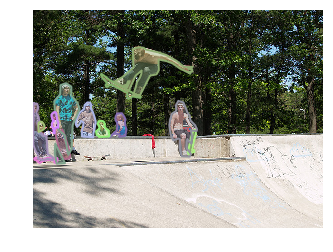

In [32]:
# load and display instance annotations
image = io.imread(os.path.join(IMAGES_DIRECTORY ,image_data['file_name']))
plt.imshow(image); plt.axis('off')
pylab.rcParams['figure.figsize'] = (98.0, 150.0)
annotation_ids = testing_coco.getAnnIds(imgIds=image_data['id'], catIds=category_ids, iscrowd=None)


annotations = testing_coco.loadAnns(annotation_ids)
print(annotations)
testing_coco.showAnns(annotations)